**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [173]:
# write your code here
import sympy as sm
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from types import SimpleNamespace
import time 

from problem2 import problem2_model
from problem3 import multistart_optimizer
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $C = (1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor


The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

In [124]:
# a. 
alpha, kappa, nu, tau, sigma, rho, epsilon, w_, w, G, C, L = sm.symbols("alpha, kappa, nu, tau, sigma, rho, epsilon, w~tilde, w, G, C, L")


C_f = kappa + w_*L


V = sm.ln(C_f**alpha * G**(1-alpha)) - nu*L**2/2

V_diff = sm.diff(V,L)

sol = sm.solve(sm.Eq(V_diff,0),L)




**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.

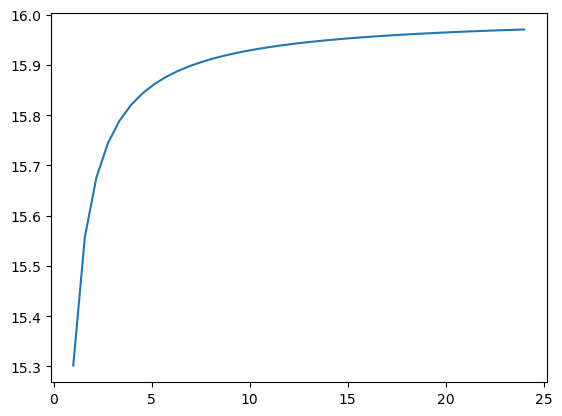

In [127]:
# write your code here
w_vector = np.linspace(1,24,40)
alpha_val = 0.5
kappa_val = 1.0
nu_val = 1/(2*16**2)
tau_val = 0.3

L_f = sol[1].subs(w_,(1-tau)*w)

Labor = sm.lambdify(args=(w,alpha,kappa,nu,tau),expr=L_f)


L_vector = []
for w_val in w_vector:
    L_val = Labor(w_val,alpha_val,kappa_val,nu_val,tau_val)
    L_vector.append(L_val)

plt.plot(w_vector,L_vector)



We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


<lambdifygenerated-1>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1/2)*(-kappa*nu + sqrt(nu*(4*alpha*w**2*(1 - tau)**2 + kappa**2*nu)))/(nu*w*(1 - tau))


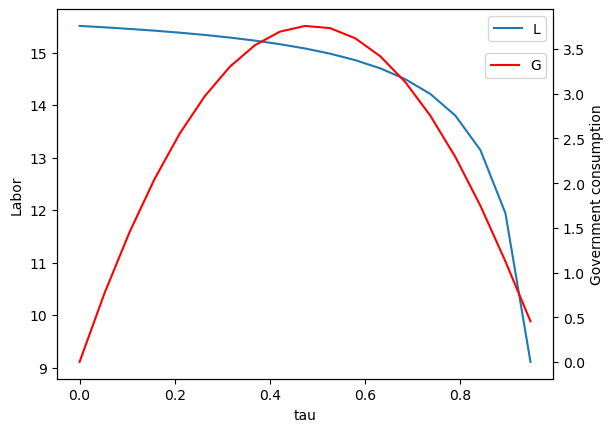

In [4]:
# write your code here
w_val = 1.0
tau_vector = np.linspace(0,1,20)

G_f = tau*w*L*(1-tau)*w
Gov_cons = sm.lambdify(args=(tau,w,L),expr=G_f)

L_vector = []
G_vector = []

for tau_val in tau_vector:
    L_val = Labor(w_val,alpha_val,kappa_val,nu_val,tau_val)
    G_val = Gov_cons(tau_val,w_val,L_val)
    L_vector.append(L_val)
    G_vector.append(G_val)


ax1= plt.subplot()

ax1.plot(tau_vector,L_vector)
ax2 = ax1.twinx()
ax2.plot(tau_vector,G_vector, color="red")

ax1.set_ylabel("Labor")
ax2.set_ylabel("Government consumption")
ax1.set_xlabel("tau")

ax1.legend("L")
ax2.legend("G",bbox_to_anchor=(1, 0.9))




**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

The optimal tax to maximize worker utility is 0.338, with utility, 1.590


<lambdifygenerated-3>:2: RuntimeWarning: divide by zero encountered in log
  return -512.0*(-0.00048828125*(0.03125 - sqrt(1.0*(tau - 1)**2 + 0.0009765625))**2 + 0.001953125*(tau - 1)**2*log(64.0*sqrt(-tau*(0.001953125 - 0.0625*sqrt(1.0*(tau - 1)**2 + 0.0009765625)))*sqrt(sqrt(1.0*(tau - 1)**2 + 0.0009765625) + 0.03125)))/(tau - 1)**2
<lambdifygenerated-3>:2: RuntimeWarning: invalid value encountered in double_scalars
  return -512.0*(-0.00048828125*(0.03125 - sqrt(1.0*(tau - 1)**2 + 0.0009765625))**2 + 0.001953125*(tau - 1)**2*log(64.0*sqrt(-tau*(0.001953125 - 0.0625*sqrt(1.0*(tau - 1)**2 + 0.0009765625)))*sqrt(sqrt(1.0*(tau - 1)**2 + 0.0009765625) + 0.03125)))/(tau - 1)**2


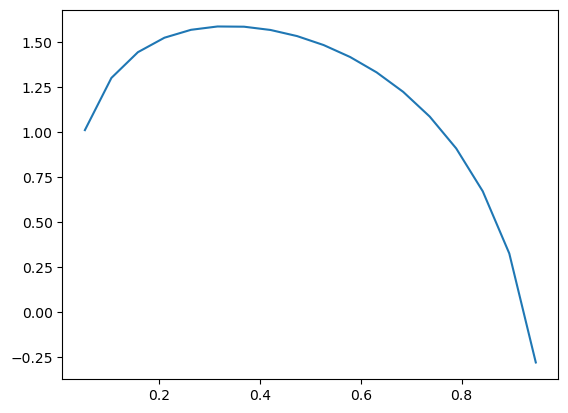

In [5]:
# write your code here
V_f = sm.simplify(V.subs({w_:w*(1-tau),G:G_f,L:L_f}))

worker_utility = sm.lambdify(args=(tau),expr=-V_f.subs({w:w_val,alpha:alpha_val,kappa:kappa_val,nu:nu_val}))

bounds = (0,1)
initial_guess = [0.5]

sol = optimize.minimize_scalar(worker_utility,method="bounded",bounds=bounds)

print(f"The optimal tax to maximize worker utility is {sol.x:.3f}, with utility, {-sol.fun:.3f}")

V_vector = []
for tau_val in tau_vector:
    V_val = worker_utility(tau_val)
    V_vector.append(-V_val)
    
plt.plot(tau_vector,V_vector)
plt.show()




A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{1-\sigma} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

Questions 5 and 6 must be answered with the general formulation, and for 2 different set of parameters:

- Set 1:  $\sigma = 1.001$, $\rho = 1.001$ and $\varepsilon = 1.0$.
- Set 2:  $\sigma = 1.5$, $\rho = 1.5$ and $\varepsilon = 1.0 $.

**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

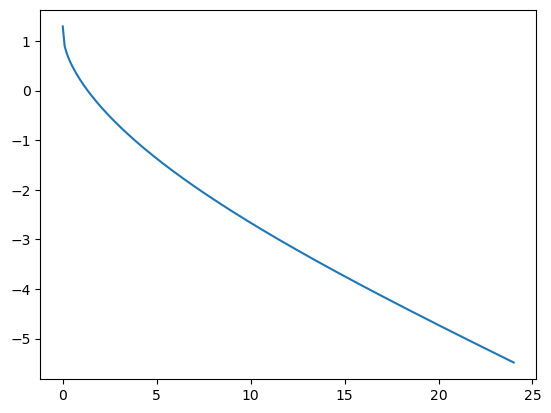

In [6]:
# write your code here
par = SimpleNamespace()

set1 = par.set1 = SimpleNamespace()
set1.sigma = 1.001
set1.rho = 1.001
set1.epsilon = 1.0

set2 = par.set2 = SimpleNamespace()
set2.sigma = 1.5
set2.rho = 1.5
set2.epsilon = 1.0

tau_val = sol.x



V = (((alpha_val*(kappa_val + (1-tau_val)*w_val*L)**((set2.sigma-1)/set2.sigma) + (1-alpha_val)*(tau_val*w_val*L)**((set2.sigma-1)/set2.sigma))**(set2.sigma/(1-set2.sigma)))**(1-set2.rho)-1)/(1-set2.rho)-(nu_val*L**(1+set2.epsilon))/(1+set2.epsilon)



**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

In [7]:
# write your code here  

## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

In [8]:
# write your code here
eta, kappa, l, w = sm.symbols("eta, kappa_t, l_t, w")

profits_t = kappa*l**(1-eta)-w*l

diff_profits_t = sm.diff(profits_t,l)

l_fun = sm.solve(sm.Eq(diff_profits_t,0),l)[0]

We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

In [111]:
# write your code here 
model = problem2_model()

model.ex_ante(10000)

11.782186302546512

Soooo, basically the value of the hairdresser is around 11,7.

Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

In [108]:
# write your code here
model.par.delta = 0.05

model.ex_ante(10000)

12.621252081133957

Soooooooooooo, BASICALLY teh value is higher.

**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

0.06066593909352527


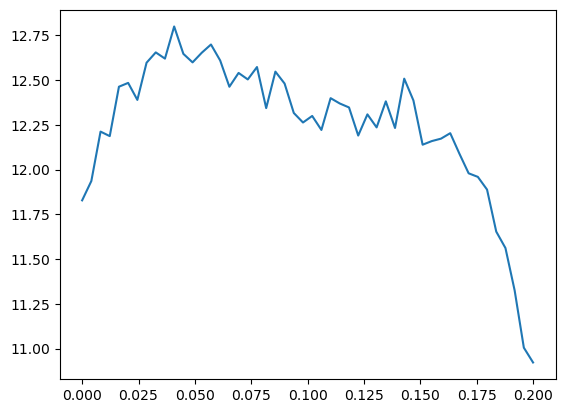

In [121]:
# write your code here
sol = model.optimize_delta(1000)
print(sol.x)

delta_vector = np.linspace(0,0.2,50)
value_vector = []

for delta in delta_vector:
    model.par.delta = delta
    value = model.ex_ante(1000)
    value_vector.append(value)

plt.plot(delta_vector,value_vector)


Our results show that the delta that maximizes H is between 0.03 and 0.06. Since it is a random distribution, it is difficult to pinpoint which is the actual result. It seems that there is a dip at delta=0.1 and another plateau until around 0.16 and then it decreases.


**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



In [ ]:
# write your code here

## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

In [132]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

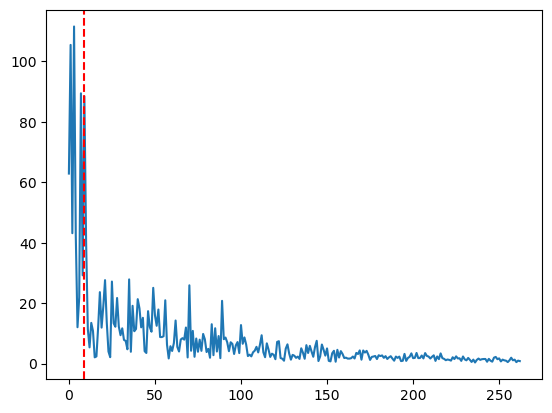

In [172]:
# write your code here
K_ = 10

x_star, x_list = multistart_optimizer(griewank,[-600,600],tau=10**-8,K_=K_,K=1000)
x_star

y_list = []
for x in x_list:
    y = griewank(x)
    y_list.append(y)

ax = plt.subplot()
ax.plot(range(len(y_list)),y_list)
ax.axvline(x=K_-1, color='r', linestyle='--')


**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

In [184]:
# write your code here
n = 10

t1_list = []
t2_list = []

for i in range(n):
    K_ = 10
    t1_start = time.time()
    multistart_optimizer(griewank,[-600,600],tau=10**-8,K_=K_,K=1000)
    t1_end = time.time()
    t1_list.append(t1_end-t1_start)

    K_ = 100
    t2_start = time.time()
    multistart_optimizer(griewank,[-600,600],tau=10**-8,K_=K_,K=1000)
    t2_end = time.time()
    t2_list.append(t2_end-t2_start)

t1_average = sum(t1_list)/len(t1_list)
t2_average = sum(t2_list)/len(t2_list)

print(f"When K_ is 10, time elapsed is, on average {t1_average}, while when K_ is 100, time elapsed is, on average, {t2_average}")



When K_ is 10, time elapsed is, on average 0.6257271051406861, while when K_ is 100, time elapsed is, on average, 0.9845626354217529


According to our results, when K_ is 10 it converges faster. But the time elapsed with K_=10 seems to be more variable than when it is 100.